## This notebook analyzes the known ISOs and produces their origins on the celestial sphere

It uses the following methodology:
- Given orbital elements from JPL small-body database
- Calculate the (RA, Dec) of the incoming velocity vector
- Plot the results on a Mollweide projection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord, solar_system_ephemeris, get_body_barycentric_posvel, CartesianRepresentation, CartesianDifferential
from astropy.time import Time

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['mathtext.fontset'] = 'cm'

First, we want to convert the orbital elements from heliocentric to barycentric frame. We want to do this by:
1. Calculate the state vector (position and velocity) in heliocentric frame at a given epoch
- First, need to convert from hyperbolic mean anomaly to hyperbolic eccentric anomaly
- Then, convert from hyperbolic eccentric anomaly to true anomaly
- Then, calculate the position and velocity in the orbital frame
- Finally, rotate the position and velocity to the heliocentric frame
2. Subtract the Sun's state vector at that epoch to get the barycentric state vector
3. Convert the barycentric state vector back to barycentric orbital elements

In [57]:
def hyperbolic_mean_to_eccentric_anomaly(M, e, tol=1e-10, max_iter=100):
    '''
    Convert hyperbolic mean anomaly to hyperbolic eccentric anomaly using Newton-Raphson method.

    Parameters
    ----------
    M : float
        Hyperbolic mean anomaly in radians
    e : float
        Eccentricity (e > 1 for hyperbolic orbits)
    tol : float
        Tolerance for convergence
    max_iter : int
        Maximum number of iterations

    Returns
    -------
    F : float
        Hyperbolic eccentric anomaly in radians
    k : int
        Number of iterations taken to converge
    '''
    if e <= 1:
        raise ValueError("Eccentricity must be greater than 1 for hyperbolic orbits.")

    # Initial guess for F
    F = M

    # Newton-Raphson iterations
    for k in range(max_iter):
        # Calculating next correction
        delta_F = (M - (e * np.sinh(F) - F)) / (e * np.cosh(F) - 1)
        
        # Calculating next approximation
        F += delta_F

        # Check for convergence
        if abs(delta_F) < tol:
            break

    return F, k+1  # Return the number of iterations as well

def OEtoRV(orbital_elements: dict) -> dict:
    '''
    Convert orbital elements to state vectors.

    Parameters
    ----------
    orbital_elements : dict
        Dictionary containing heliocentric orbital elements:
        - a: Semi-major axis (astropy Quantity with length unit)
        - e: Eccentricity (float)
        - i: Inclination (astropy Quantity with angle unit)
        - Omega: Longitude of ascending node (astropy Quantity with angle unit)
        - omega: Argument of perihelion (astropy Quantity with angle unit)
        - M: Mean anomaly (astropy Quantity with angle unit)
        - epoch: Epoch of the elements (astropy Time object)

    Returns
    -------
    (r, v) : tuple of np.ndarray
        Position (r) and velocity (v) vectors in heliocentric frame [km] and [km/s]
    '''
    # Unpacking orbital elements and converting to appropriate units
    a = orbital_elements['a'].to(u.km).value
    e = orbital_elements['e']
    i = orbital_elements['i'].to(u.rad).value
    Omega = orbital_elements['Omega'].to(u.rad).value
    omega = orbital_elements['omega'].to(u.rad).value
    M = orbital_elements['M'].to(u.rad).value

    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]
    h = np.sqrt(-mu_sun * abs(a) * (1 - e**2))  # Specific angular momentum [km^2/s]

    # Defining rotational matrices
    Rz_Omega = np.array([
        [ np.cos(Omega), np.sin(Omega), 0.0],
        [-np.sin(Omega), np.cos(Omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    Rx_i = np.array([
        [1.0,  0.0,       0.0],
        [0.0,  np.cos(i), np.sin(i)],
        [0.0, -np.sin(i), np.cos(i)]
    ])

    Rz_omega = np.array([
        [ np.cos(omega), np.sin(omega), 0.0],
        [-np.sin(omega), np.cos(omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    # DCM to go from inertial (heliocentric) frame to orbital frame
    R_OI = Rz_omega @ Rx_i @ Rz_Omega

    # Calculating position of object in the orbital frame
    # Solving Kepler's equation for Eccentric Anomaly (E) using Newton-Raphson method
    F, k = hyperbolic_mean_to_eccentric_anomaly(M, e)

    # Calculating true anomaly (nu) from hyperbolic eccentric anomaly (F)
    nu = 2 * np.arctan2( np.sqrt((e + 1) / (e - 1)) * np.tan(F / 2), 1 )

    # Calculating distance (r) from the focus (Sun) to the object
    r_mag = a * (1 - e*np.cosh(F))

    # Position in orbital frame [km]
    r_orbital = np.array([
        r_mag * np.cos(nu),
        r_mag * np.sin(nu),
        0.0
    ])

    # Velocity in orbital frame [km/s]
    v_orbital = np.array([
        (mu_sun / h) * (-np.sin(nu)),
        (mu_sun / h) * (e + np.cos(nu)),
        0.0
    ])

    # Rotating position and velocity to heliocentric frame
    r_heliocentric = np.transpose(R_OI) @ r_orbital * u.km
    v_heliocentric = np.transpose(R_OI) @ v_orbital * u.km / u.s

    return (r_heliocentric, v_heliocentric)

def helio_RV_to_bary_RV(r_heliocentric, v_heliocentric, M, a, perihelion_epoch):
    '''
    Convert heliocentric state vectors to barycentric state vectors.

    Parameters
    ----------
    r_heliocentric : np.ndarray
        Position vector in heliocentric frame [km]
    v_heliocentric : np.ndarray
        Velocity vector in heliocentric frame [km/s]
    a : astropy Quantity with length unit
        Heliocentric semi-major axis
    M : astropy Quantity with angle unit
        Mean anomaly
    perihelion_epoch : astropy Time object
        Epoch of the perihelion passage

    Returns
    -------
    (r, v) : tuple of np.ndarray
        Position (r) and velocity (v) vectors in barycentric frame [km] and [km/s]
    '''
    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    # Converting values
    a = a.to(u.km).value
    M = M.to(u.rad).value

    # Now, we must find what time these elements were valid at, and get the Sun's state vector at that time
    # The epoch given is the perhelion passage time, so we need to propagate to the time of interest
    # First, calculate mean motion (n)
    n = np.sqrt(mu_sun / abs(a)**3)  # Mean motion [rad/s]

    # Now, using M = n * (t - perihelion_epoch), we can find the time of interest
    # Rearranging gives t = M/n + perihelion_epoch
    t = (M / n) * u.s + perihelion_epoch

    # The time t is the time at which the orbital elements are valid
    # We will use this time to get the Sun's state vector
    with solar_system_ephemeris.set('jpl'):
        sun_posvel = get_body_barycentric_posvel('sun', t)
    
    sun_pos = sun_posvel[0].get_xyz().to(u.km)
    sun_vel = sun_posvel[1].get_xyz().to(u.km / u.s)

    # Transforming to barycentric frame
    r_barycentric = r_heliocentric + sun_pos
    v_barycentric = v_heliocentric + sun_vel

    return (r_barycentric, v_barycentric)

def RVtoOE(r_barycentric, v_barycentric):
    '''
    Convert barycentric state vectors to barycentric orbital elements.

    Parameters
    ----------
    r_barycentric : np.ndarray
        Position vector in barycentric frame [km]
    v_barycentric : np.ndarray
        Velocity vector in barycentric frame [km/s]

    Returns
    -------
    orbital_elements : dict
        Dictionary containing heliocentric orbital elements:
        - a: Semi-major axis (astropy Quantity with length unit)
        - e: Eccentricity (float)
        - i: Inclination (astropy Quantity with angle unit)
        - Omega: Longitude of ascending node (astropy Quantity with angle unit)
        - omega: Argument of perihelion (astropy Quantity with angle unit)
        - M: Mean anomaly (astropy Quantity with angle unit)
        - epoch: Epoch of the elements (astropy Time object)
    '''
    r_barycentric = r_barycentric.to(u.km).value
    v_barycentric = v_barycentric.to(u.km / u.s).value

    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    # Now, we need to convert the barycentric state vector back to barycentric orbital elements
    r_mag_barycentric = np.linalg.norm(r_barycentric)
    v_mag_barycentric = np.linalg.norm(v_barycentric)

    # Specific angular momentum vector
    h_barycentric = np.cross(r_barycentric, v_barycentric)
    h_mag_barycentric = np.linalg.norm(h_barycentric)

    # Calculating semimajor axis (a) [km]
    a = 1 / (2 / np.linalg.norm(r_barycentric) - np.linalg.norm(v_barycentric)**2 / mu_sun)

    # Calculating eccentricity (e)
    e_vector = (1/mu_sun) * (np.cross(v_barycentric, h_barycentric) - mu_sun*r_barycentric/r_mag_barycentric)
    e = np.linalg.norm(e_vector)

    # Calculating orbital frame basis vectors
    i_e = e_vector / e  # Unit vector in direction of eccentricity
    i_h = h_barycentric / h_mag_barycentric  # Unit vector in direction of angular momentum
    i_y = np.cross(i_h, i_e)  # Unit vector perpendicular to both

    # Constructing DCM from inertial to orbital frame
    R_OI_barycentric = np.vstack((i_e, i_y, i_h))

    # Calculating inclination (i) [rad]
    i = np.arccos(R_OI_barycentric[2, 2])

    # Calculating longitude of ascending node (Omega) [rad]
    Omega = np.arctan2(i_h[0]/np.sin(i), -i_h[1]/np.sin(i))

    if Omega < 0:
        Omega += 2 * np.pi

    # Calculating argument of perihelion (omega) [rad]
    omega = np.arctan2(i_e[2]/np.sin(i), i_y[2]/np.sin(i))

    if omega < 0:
        omega += 2 * np.pi

    # Calculating true anomaly (nu) [rad]
    r_orbital = R_OI_barycentric @ r_barycentric
    nu = np.arctan2(r_orbital[1], r_orbital[0])

    # Calculating hyperbolic eccentric anomaly (F) [rad]
    F = 2 * np.arctanh( np.tan(nu / 2) * np.sqrt((e - 1) / (e + 1)) )

    # Calculating hyperbolic mean anomaly (M) [rad]
    M = e * np.sinh(F) - F

    # Inserting values into dictionary and converting to appropriate units
    orbital_elements = {
        'a': (a * u.km).to(u.au),
        'e': e,
        'i': (i * u.rad).to(u.deg),
        'Omega': (Omega * u.rad).to(u.deg),
        'omega': (omega * u.rad).to(u.deg),
        'M': (M * u.rad).to(u.deg),
    }

    return orbital_elements

def OEtoRAD(a: u.Quantity, e: float, i_deg: u.Quantity, Omega_deg: u.Quantity, omega_deg: u.Quantity, is_barycentric=False) -> tuple[float, float, np.ndarray, np.ndarray]:
    '''
    Convert orbital elements to RA and Dec of the incoming velocity vector if an ISO.

    Parameters
    ----------
    a : float
        Semi-major axis of the orbit (in AU).
    e : float
        Eccentricity of the orbit.
    i_deg : float
        Inclination of the orbit (in degrees).
    Omega_deg : float
        Longitude of the ascending node (in degrees).
    omega_deg : float
        Argument of perihelion (in degrees).
    is_barycentric : bool
        If True, convert to barycentric coordinates.

    Returns
    -------
    ra : float
        Right Ascension of the incoming velocity vector (in degrees).
    dec : float
        Declination of the incoming velocity vector (in degrees).
    '''
    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    # Convert angles from degrees to radians
    i = i_deg.to(u.rad).value
    Omega = Omega_deg.to(u.rad).value
    omega = omega_deg.to(u.rad).value

    # Convert semi-major axis to meters
    a = a.to(u.km).value

    # Hyperbola: e > 1, a < 0
    # Asymptote true anomaly magnitude:
    # cos(nu_inf) = -1/e
    nu_inf = np.arccos(-1.0 / e)      # in radians
    nu_in = -nu_inf                   # incoming branch (before perihelion)

    # Specific angular momentum (magnitude) h = sqrt(mu * a * (e^2 - 1))
    h = np.sqrt(-mu_sun * abs(a) * (1.0 - e**2))

    # Distance at true anomaly nu:
    r = (a * (1.0 - e**2)) / (1.0 + e * np.cos(nu_in))   # km
    print(1 + e * np.cos(nu_in))
    
    # Radial and transverse velocities in perifocal frame:
    v_r = (mu_sun / h) * e * np.sin(nu_in)
    v_t = (mu_sun / h) * (1.0 + e * np.cos(nu_in))

    # Position in perifocal frame
    r_pf = np.array([r * np.cos(nu_in), r * np.sin(nu_in), 0.0])

    # Velocity in perifocal frame
    v_pf = np.array([v_r * np.cos(nu_in) - v_t * np.sin(nu_in),
                     v_r * np.sin(nu_in) + v_t * np.cos(nu_in),
                     0.0])
    
    # Rotation matrix from perifocal -> ECI (ICRS/ecliptic depending on elements)
    # R = R_z(Omega) @ R_x(i) @ R_z(omega) (3-1-3 rotation)
    Rz_Omega = np.array([
        [np.cos(Omega), -np.sin(Omega), 0.0],
        [np.sin(Omega),  np.cos(Omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    Rx_i = np.array([
        [1.0, 0.0,        0.0],
        [0.0, np.cos(i), -np.sin(i)],
        [0.0, np.sin(i),  np.cos(i)]
    ])

    Rz_omega = np.array([
        [np.cos(omega), -np.sin(omega), 0.0],
        [np.sin(omega),  np.cos(omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    R = Rz_Omega @ Rx_i @ Rz_omega

    r_eci = R @ r_pf   # km
    v_eci = R @ v_pf   # km/s

    # Incoming velocity vector is v_eci (points toward Sun for incoming object).
    # Radiant is opposite direction (the direction it came from)
    v_unit = v_eci / np.linalg.norm(v_eci)
    radiant_unit = -v_unit

    # Convert to RA, Dec (ICRS) using cartesian -> skycoord
    # Coordinates expect units; astropy's SkyCoord.from_cartesian wants cartesian representation.
    sc = SkyCoord(x=radiant_unit[0], y=radiant_unit[1], z=radiant_unit[2],
                  representation_type='cartesian', frame='icrs')
    
    ra = sc.spherical.lon.deg
    dec = sc.spherical.lat.deg
    
    return ra * u.deg, dec * u.deg, v_eci * u.km / u.s, r_eci * u.km

Initializing orbital elements from JPL small-body database for known ISOs

In [58]:
oumuamua_heliocentric_elements = {
    'a': -1.27234500742808e+01 * u.au,  # Semi-major axis
    'e': 1.201133796102373e+01,      # Eccentricity
    'i': 122.7417062847286 * u.deg,  # Inclination
    'Omega': 24.59690955523242 * u.deg,  # Longitude of ascending node
    'omega': 241.8105360304898 * u.deg,  # Argument of perihelion
    'M': 51.1576197938249 * u.deg,  # Mean anomaly
    'epoch': Time('2458006.007321375231', format='jd', scale='tdb')  # Time of perihelion passage
}

borisov_heliocentric_elements = {
    'a': -0.8514922551937886 * u.au,  # Semi-major axis
    'e': 3.356475782676596,      # Eccentricity
    'i': 44.05264247909138 * u.deg,  # Inclination
    'Omega': 308.1477292269942 * u.deg,  # Longitude of ascending node
    'omega': 209.1236864378081 * u.deg,  # Argument of perihelion
    'M': 34.4294703072178 * u.deg,  # Mean anomaly
    'epoch': Time('2458826.052845906059', format='jd', scale='tdb')  # Time of perihelion passage
}

atlas_heliocentric_elements = {
    'a': -0.263915917517816 * u.au,  # Semi-major axis
    'e': 6.139587836355706,      # Eccentricity
    'i': 175.1131015287974 * u.deg,  # Inclination
    'Omega': 322.1568699043938 * u.deg,  # Longitude of ascending node
    'omega': 128.0099421020839 * u.deg,  # Argument of perihelion
    'M': -723.1822479798254 * u.deg,  # Mean anomaly
    'epoch': Time('2460977.981439259343', format='jd', scale='tdb')  # Time of perihelion passage
}

Initializing orbital element uncertainties from JPL small-body database for known ISOs

In [59]:
oumuamua_heliocentric_uncertainties = {
    'a': .00010015 * u.au,  # Semi-major axis
    'e': 2.1064E-5,      # Eccentricity
    'i': .00028826 * u.deg,  # Inclination
    'Omega': .00025422 * u.deg,  # Longitude of ascending node
    'omega': .0012495 * u.deg,  # Argument of perihelion
    'M': .00026424 * u.deg,  # Mean anomaly
    'epoch': Time('.00026424', format='jd', scale='tdb')  # Time of perihelion passage
}

borisov_heliocentric_uncertainties = {
    'a': 5.8802E-6 * u.au,  # Semi-major axis
    'e': 1.9039E-5,      # Eccentricity
    'i': 1.6673E-5 * u.deg,  # Inclination
    'Omega': 4.5021E-5 * u.deg,  # Longitude of ascending node
    'omega': .00011012 * u.deg,  # Argument of perihelion
    'M': .00043173 * u.deg,  # Mean anomaly
    'epoch': Time('.00014206', format='jd', scale='tdb')  # Time of perihelion passage
}

atlas_heliocentric_uncertainties = {
    'a': 1.5416E-5 * u.au,  # Semi-major axis
    'e': .00080296,      # Eccentricity
    'i': 7.7646E-5 * u.deg,  # Inclination
    'Omega': .0014821 * u.deg,  # Longitude of ascending node
    'omega': .0010237 * u.deg,  # Argument of perihelion
    'M': .05901 * u.deg,  # Mean anomaly
    'epoch': Time('.00060348', format='jd', scale='tdb')  # Time of perihelion passage
}

Varying orbital elements within their uncertainties to get a distribution of incoming directions

In [60]:
samples = 1000

oumuamua_elements_list = []
borisov_elements_list = []
atlas_elements_list = []

oumuamua_ras = []
oumuamua_decs = []

borisov_ras = []
borisov_decs = []

atlas_ras = []
atlas_decs = []

for sample in range(samples):
    print(sample)
    # Oumuamua
    oe_oumuamua = {
        'a': np.random.normal(oumuamua_heliocentric_elements['a'].value, oumuamua_heliocentric_uncertainties['a'].value) * u.au,
        'e': np.random.normal(oumuamua_heliocentric_elements['e'], oumuamua_heliocentric_uncertainties['e']),
        'i': np.random.normal(oumuamua_heliocentric_elements['i'].value, oumuamua_heliocentric_uncertainties['i'].value) * u.deg,
        'Omega': np.random.normal(oumuamua_heliocentric_elements['Omega'].value, oumuamua_heliocentric_uncertainties['Omega'].value) * u.deg,
        'omega': np.random.normal(oumuamua_heliocentric_elements['omega'].value, oumuamua_heliocentric_uncertainties['omega'].value) * u.deg,
        'M': np.random.normal(oumuamua_heliocentric_elements['M'].value, oumuamua_heliocentric_uncertainties['M'].value) * u.deg,
        'epoch': Time(f'{np.random.normal(oumuamua_heliocentric_elements["epoch"].value, oumuamua_heliocentric_uncertainties["epoch"].value)}', format='jd', scale='tdb')
    }
    oumuamua_elements_list.append(oe_oumuamua)

    r_helio, v_helio = OEtoRV(oe_oumuamua)
    r_bary, v_bary = helio_RV_to_bary_RV(r_helio, v_helio, oe_oumuamua['M'], oe_oumuamua['a'], oe_oumuamua['epoch'])
    oe_bary = RVtoOE(r_bary, v_bary)

    ra, dec, v_vec, r_vec = OEtoRAD(oe_bary['a'], oe_bary['e'], oe_bary['i'], oe_bary['Omega'], oe_bary['omega'], is_barycentric=True)
    oumuamua_ras.append(ra.value)
    oumuamua_decs.append(dec.value)

oumuamua_ras = np.array(oumuamua_ras)
oumuamua_decs = np.array(oumuamua_decs)

0
0.0
1
1.6653345369377348e-15
2
8.881784197001252e-16
3
-2.220446049250313e-16
4
1.1102230246251565e-15
5
1.3322676295501878e-15
6
1.887379141862766e-15
7
-6.661338147750939e-16
8
1.3322676295501878e-15
9
0.0
10
0.0
11
1.2212453270876722e-15
12
1.6653345369377348e-15
13
4.440892098500626e-16
14
0.0
15
1.6653345369377348e-15
16
1.4432899320127035e-15
17
1.887379141862766e-15
18
1.2212453270876722e-15
19
2.220446049250313e-16
20
1.6653345369377348e-15
21
1.6653345369377348e-15
22
5.551115123125783e-16
23
-2.220446049250313e-16
24
-2.220446049250313e-16
25
-4.440892098500626e-16
26
6.661338147750939e-16
27
0.0
28
1.1102230246251565e-16
29
-4.440892098500626e-16
30
1.1102230246251565e-16
31
-2.220446049250313e-16
32
5.551115123125783e-16
33
1.3322676295501878e-15
34
1.2212453270876722e-15
35
-4.440892098500626e-16
36
4.440892098500626e-16
37
0.0
38
1.6653345369377348e-15
39
1.3322676295501878e-15
40
7.771561172376096e-16
41
8.881784197001252e-16
42
1.2212453270876722e-15
43
1.443289932012

/var/folders/39/mb5cwg0x4h18n1y377g5rs9c0000gn/T/ipykernel_90141/2497760902.py:316: RuntimeWarning: divide by zero encountered in scalar divide
  r = (a * (1.0 - e**2)) / (1.0 + e * np.cos(nu_in))   # km
/var/folders/39/mb5cwg0x4h18n1y377g5rs9c0000gn/T/ipykernel_90141/2497760902.py:353: RuntimeWarning: invalid value encountered in matmul
  r_eci = R @ r_pf   # km


-2.220446049250313e-16
845
1.3322676295501878e-15
846
9.992007221626409e-16
847
1.9984014443252818e-15
848
1.3322676295501878e-15
849
6.661338147750939e-16
850
-4.440892098500626e-16
851
1.7763568394002505e-15
852
1.3322676295501878e-15
853
8.881784197001252e-16
854
1.4432899320127035e-15
855
-6.661338147750939e-16
856
1.1102230246251565e-15
857
3.3306690738754696e-16
858
-4.440892098500626e-16
859
-2.220446049250313e-16
860
0.0
861
-4.440892098500626e-16
862
-2.220446049250313e-16
863
1.5543122344752192e-15
864
5.551115123125783e-16
865
-2.220446049250313e-16
866
2.220446049250313e-16
867
5.551115123125783e-16
868
7.771561172376096e-16
869
6.661338147750939e-16
870
9.992007221626409e-16
871
0.0
872
1.7763568394002505e-15
873
-2.220446049250313e-16
874
1.7763568394002505e-15
875
-4.440892098500626e-16
876
7.771561172376096e-16
877
-4.440892098500626e-16
878
1.1102230246251565e-15
879
7.771561172376096e-16
880
3.3306690738754696e-16
881
9.992007221626409e-16
882
3.3306690738754696e-16
8

We want to compute the incoming velocity vector $v_{\infty}$ for each ISO. With that, we can compute the RA and Dec of the incoming direction.

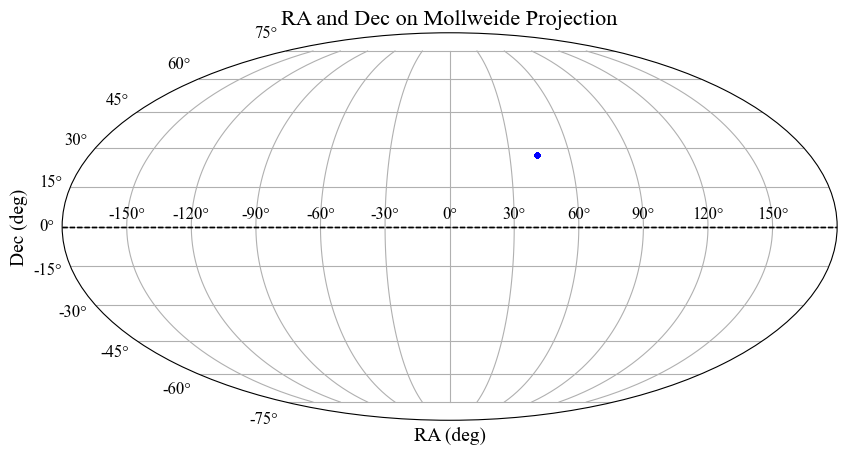

In [64]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(projection='mollweide')

ra_rad = np.deg2rad(oumuamua_ras)
dec_rad = np.deg2rad(oumuamua_decs)

ax.scatter(ra_rad - np.pi, dec_rad, marker='.', color='blue', label='ISOs')

ax.hlines(0, -np.pi, np.pi, colors='black', linestyles='dashed', linewidth=1)

ax.plot([-np.pi, np.pi], [0, 0], color='black', linestyle='dashed', linewidth=1)

# ax.set_xlim(np.deg2rad(30), np.deg2rad(60))
# ax.set_ylim(np.deg2rad(15), np.deg2rad(30))

ax.grid(True)
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")

ax.set_title("RA and Dec on Mollweide Projection")

plt.show()

In [7]:
# radiants -> unit vectors (example list ra_list, dec_list)
ra_list = np.array([ra])  # extend with real sample RA values
dec_list = np.array([dec])

def radec_to_unit(ra_deg, dec_deg):
    ra = np.deg2rad(ra_deg)
    dec = np.deg2rad(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.vstack([x,y,z]).T

X = radec_to_unit(ra_list, dec_list)
R = X.sum(axis=0)
Rnorm = np.linalg.norm(R)
mean_dir = R / Rnorm
# convert mean_dir to RA/Dec
sc = SkyCoord(x=mean_dir[0], y=mean_dir[1], z=mean_dir[2], representation_type='cartesian', frame='icrs')
print("Mean resultant RA,Dec:", sc.spherical.lon.deg, sc.spherical.lat.deg)

TypeError: only dimensionless scalar quantities can be converted to Python scalars

NameError: name 'ra_list' is not defined

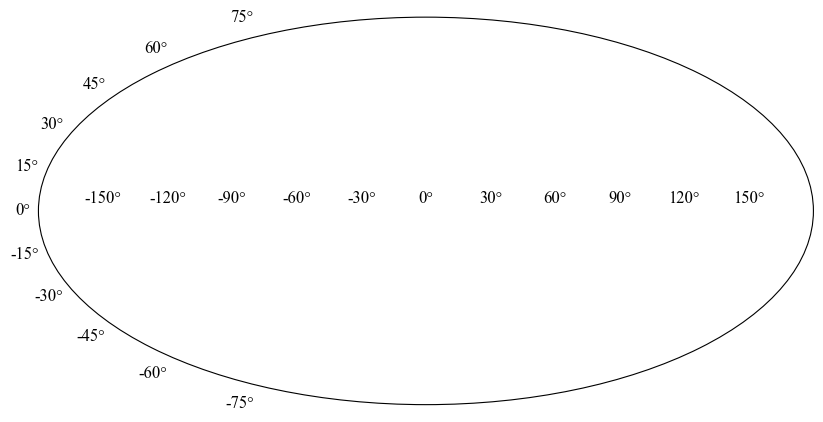

In [ ]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(projection='mollweide')

ra_rad = np.deg2rad(ra_list)
dec_rad = np.deg2rad(dec_list)

ax.scatter(ra_rad - np.pi, dec_rad, marker='.', color='blue', label='ISOs')

ax.grid(True)
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")

ax.set_title("RA and Dec on Mollweide Projection")

plt.show()